In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from IPython.display import Math

plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.grid"] = True

# Вычисление энергии упругой деформации балки на упругом основании и контроль решения по энергии

Рассмотрим на примере о нагружении бесконечной балки сосредоточенной силой $P$.

Решение дифференциального уравнения $v^{IV} + 4 m^4 v = 0$ запишем в виде

$$v(z) = A e^{- m z} \cos(mz + \psi),$$

где $A$, $\psi$ &mdash; неизвестные амплитуда и фаза функции прогибов $v(z)$. Выполним все выкладки в безразмерной форме. Для этого введем безразмерную координату $\xi$: $z = L\xi$, где $L$ &mdash; масштаб длины балки (далее он сократится), а прогибы представим в долях $\frac{PL^3}{EJ_x}$:
$$v(\xi) = \frac{PL^3}{EJ_x} A e^{-m L \xi} \cos(m L \xi + \psi) = a e^{-\lambda \xi} \cos(\lambda \xi + \psi),$$
где $a$: $A = a \cdot \frac{PL^3}{EJ_x}$ &mdash; безразмерная амплитуда, $\lambda = mL$ &mdash; математическая длина балки.

Безразмерный угол поворота:
$$\vartheta(\xi) = - \frac{d}{Ld\xi} \hat{v}(\xi) \cdot \frac{PL^3}{EJ_x} = \hat{\vartheta}(\xi) \cdot \frac{PL^2}{EJ_x}.$$

Безразмерный изгибающий момент:
$$M_x(\xi) = EJ_x \frac{d}{Ld\xi}\hat{\vartheta}(\xi) \cdot \frac{PL^2}{EJ_x} = \hat{M}_x \cdot PL.$$

Безразмерная поперечная сила:
$$Q_y(\xi) = \frac{d}{Ld\xi}\hat{M}_x(\xi) \cdot PL = \hat{Q}_y \cdot P.$$


Граничные условия (симметрия при $\xi=0$):
$$\begin{align*}
\vartheta(0) = - \frac{PL^3}{EJ_x} \cdot \frac{d\hat{v}}{Ld\xi}\Bigr|_{\xi=0} &= 0 &\to \frac{d\hat{v}}{d\xi}\Bigr|_{\xi=0} &= 0 \\
Q_y(0) = -EJ_x \cdot \frac{PL^3}{EJ_x} \frac{d^3\hat{v}}{L^3 d\xi^3}\Bigr|_{\xi=0} &= -\frac{1}{2}P &\to \frac{d^3\hat{v}}{d\xi^3}\Bigr|_{\xi=0} &= \frac{1}{2}
\end{align*}$$

In [4]:
ξ, λ, a, ψ = sp.symbols("xi lambda a psi")

Найдем значения констант из граничных условий:

In [5]:
v = a * sp.exp(- λ * ξ) * sp.cos(λ * ξ + ψ)

eqn1 = v.diff(ξ, 1).subs(ξ, 0)
eqn2 = v.diff(ξ, 3).subs(ξ, 0) - sp.Rational(1, 2)
ψ0 = sp.solve(eqn1, ψ)[0]
a0 = sp.solve(eqn2.subs(ψ, ψ0), a)[0]

display(Math(rf"a = {sp.latex(a0)}"))
display(Math(rf"\psi = {sp.latex(ψ0)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Подставим найденные константы в исходную функцию и сформируем решение для целой балки, воспользовавшись симметрией для симметричных факторов (прогиб и изгибающий момент) и косой симметрией для кососимметричных факторов (угол поворота и поперечная сила).

In [6]:
sol = {a: a0, ψ: ψ0}
v = v.subs(sol)
ϑ = -v.diff(ξ, 1)
M = ϑ.diff(ξ, 1)
Q = M.diff(ξ, 1)

v_fun = sp.lambdify((ξ, λ), v.subs(ξ, sp.Abs(ξ)), modules=["numpy"])
ϑ_fun = sp.lambdify((ξ, λ), ϑ.subs(ξ, sp.Abs(ξ)) * sp.sign(ξ), modules=["numpy"])
M_fun = sp.lambdify((ξ, λ), M.subs(ξ, sp.Abs(ξ)), modules=["numpy"])
Q_fun = sp.lambdify((ξ, λ), Q.subs(ξ, sp.Abs(ξ)) * sp.sign(ξ), modules=["numpy"])

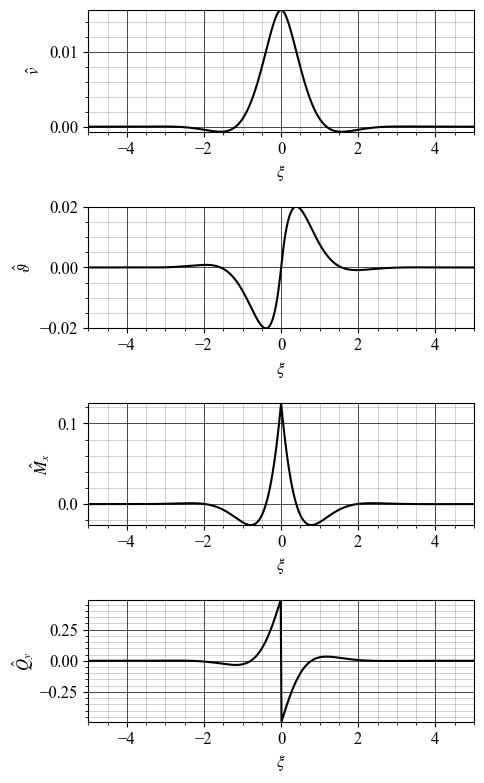

In [7]:
ξξ = np.linspace(-5.0, 5.0, 1001)
λ0 = 2.0

plot_list=[(v_fun(ξξ, λ0), r"$\hat{v}$"), 
           (ϑ_fun(ξξ, λ0), r"$\hat{\vartheta}$"), 
           (M_fun(ξξ, λ0), r"$\hat{M}_x$"), 
           (Q_fun(ξξ, λ0), r"$\hat{Q}_y$")]

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(5, 8))

for i, curve in enumerate(plot_list):
    ax[i].plot(ξξ, curve[0], "k")
    ax[i].set_xlabel(r"$\xi$")
    ax[i].set_ylabel(curve[1])
    ax[i].margins(0)
    ax[i].minorticks_on()
    ax[i].grid(True, which="major", color="k", lw=0.5)
    ax[i].grid(True, which="minor", color="k", lw=0.5, alpha=0.25)

fig.tight_layout()

Энергетический баланс выражается следующим образом:

$$\frac{1}{2} \int \limits_{-\infty}^{+\infty} \frac{M_x^2}{EJ_x} \; dz + \frac{1}{2} \int \limits_{-\infty}^{+\infty} k v^2 \; dz = \frac{1}{2} P \cdot v(0)$$

и представляет собой равенство между суммой энергий деформации изгиба балки и упругого основания и работой силы $P$. Обезразмерим:

$$\frac{1}{2} \frac{P^2 L^2}{EJ_x} \int \limits_{-\infty}^{+\infty} \hat{M}_x^2 \; Ld\xi + \frac{1}{2} \frac{P^2 L^6}{(EJ_x)^2} k \int \limits_{-\infty}^{+\infty} \hat{v}^2 \; Ld\xi = \frac{1}{2} \frac{P L^3}{EJ_x} P \cdot \hat{v}(0).$$

Вспомним, что $\frac{kL^4}{EJ_x} = 4 \lambda^4$, и сократим лишнее ($\frac{1}{2}$ оставим в качестве напоминания о теореме Клапейрона):

$$\frac{1}{2} \int \limits_{-\infty}^{+\infty} \hat{M}_x^2 \; d\xi + \frac{1}{2} \cdot 4 \lambda^4 \cdot \int \limits_{-\infty}^{+\infty} \hat{v}^2 \; d\xi = \frac{1}{2}\hat{v}(0).$$

In [8]:
U_bend = 0.5 * simpson(M_fun(ξξ, λ0)**2, ξξ)
U_found = 2 * λ0**4 * simpson(v_fun(ξξ, λ0)**2, ξξ)
W_p = 0.5 * v_fun(0, λ0) 
print(f"Энергия деформации балки и упругого основания: {U_bend + U_found : 12.10f}")
print(f"Работа внешних нагрузок: {W_p : 12.10f}")
print(f"Погрешность по закону сохранения энергии: {(U_bend + U_found - W_p) / W_p: 14.10E}")

Энергия деформации балки и упругого основания:  0.0078125001
Работа внешних нагрузок:  0.0078125000
Погрешность по закону сохранения энергии:  1.2158359874E-08
